In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from matplotlib import colors
import pandas as pd

%matplotlib inline

Funkcje do zaimplementowania:

In [2]:
#konwerter: nie trzeba implementować samemu, można wykorzystać funkcję z bilbioteki
def hsv2rgb(h, s, v):
    if (s == 0):
        return(v, v, v)
    else:
        hi = np.floor(h/60.0)
        f = h/60.0 - hi
        p = v * (1 - s)
        q = v * (1 - (s * f))
        t = v * (1 - (s * (1 - f)))
    if (hi == 0):
        return (v, t, p)
    elif (hi == 1):
        return (q, v, p)
    elif (hi == 2):
        return (p, v, t)
    elif (hi == 3):
        return (p, q, v)
    elif (hi == 4):
        return (t, p, v)
    else:
        return (v, p, q)

# poniżej znajdują się funkcje modelujące kolejne gradienty z zadania.
# v to pozycja na osi ox: v jest od 0 do 1. Zewnetrzna funkcja wywołuje te metody podając
# różne v i oczekując trójki RGB bądź HSV reprezentującej kolor. Np. (0,0,0) w RGB to kolor czarny. 
# Należy uwikłać v w funkcję modelującą kolor. W tym celu dla kolejnych gradientów trzeba przyjąć 
# sobie jakieś punkty charakterystyczne,
# np. widzimy, że po lewej stronie (dla v = 0) powinien być kolor zielony a w środku niebieski (dla v = 0.5),
# a wszystkie punkty pomiędzy należy interpolować liniowo (proporcjonalnie). 

def gradient_rgb_bw(v):
    return (v, v, v)


def gradient_rgb_gbr(v):
    if (v < 0.5):
        return (0, 1 - 2 * v, 2 * v)
    else:
        return (2 * v - 1, 0, 2 - 2*v)


def gradient_rgb_gbr_full(v):
    colors = 4.0 * v
    new_v = colors % 1.0
    if (colors <= 1.0):
        return (0, 1, new_v)
    elif (colors <= 2.0):
        return (0, 1 - new_v, 1)
    elif (colors <= 3.0):
        return (new_v, 0, 1)
    else:
        return(1, 0, 1 - new_v)


def gradient_rgb_wb_custom(v):
    colors = 7.0 * v
    new_v = colors % 1.0
    if (colors <= 1.0):
        return (1, 1 - new_v, 1)
    elif (colors <= 2.0):
        return (1 - new_v, 0, 1)
    elif (colors <= 3.0):
        return (0, new_v, 1)
    elif (colors <= 4.0):
        return (0, 1, 1 - new_v)
    elif (colors <= 5.0):
        return (new_v, 1, 0)
    elif (colors <= 6.0):
        return (1, 1 - new_v, 0)
    else:
        return (1 - new_v, 0, 0)


def gradient_hsv_bw(v):
    return hsv2rgb(0, 0, v)


def gradient_hsv_gbr(v):
    h = 120 + 240 * v
    return hsv2rgb(h, 1, 1)

def gradient_hsv_unknown(v):
    h = 120 - 120 * v
    return hsv2rgb(h, 0.5, 1)


def gradient_hsv_custom(v):
    return hsv2rgb(360.0 * v, 1 - v, 1)

In [3]:
def plot_color_gradients(gradients, names):
    # For pretty latex fonts (commented out, because it does not work on some machines)
    plt.rc('font', family='serif', serif='Times New Roman', size=10)
    plt.rc('legend', fontsize=10)

    column_width_pt = 400         # Show in latex using \the\linewidth
    pt_per_inch = 72
    size = column_width_pt / pt_per_inch

    fig, axes = plt.subplots(nrows=len(gradients), sharex=True, figsize=(size, 0.75 * size))
    fig.subplots_adjust(top=1.00, bottom=0.05, left=0.25, right=0.95)


    for ax, gradient, name in zip(axes, gradients, names):
        # Create image with two lines and draw gradient on it
        img = np.zeros((2, 1024, 3))
        for i, v in enumerate(np.linspace(0, 1, 1024)):
            img[:, i] = gradient(v)

        im = ax.imshow(img, aspect='auto')
        im.set_extent([0, 1, 0, 1])
        ax.yaxis.set_visible(False)

        pos = list(ax.get_position().bounds)
        x_text = pos[0] - 0.25
        y_text = pos[1] + pos[3]/2.
        fig.text(x_text, y_text, name, va='center', ha='left', fontsize=10)

    fig.savefig('my-gradients.pdf')

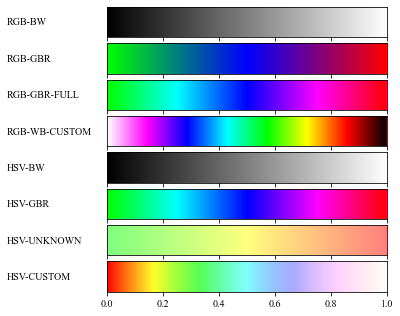

In [4]:
def toname(g):
    return g.__name__.replace('gradient_', '').replace('_', '-').upper()
    
gradients = (gradient_rgb_bw, gradient_rgb_gbr, gradient_rgb_gbr_full, gradient_rgb_wb_custom,
                 gradient_hsv_bw, gradient_hsv_gbr, gradient_hsv_unknown, gradient_hsv_custom)

plot_color_gradients(gradients, [toname(g) for g in gradients])

In [5]:
dem = pd.read_csv("http://www.cs.put.poznan.pl/mtomczyk/kck/Lab3_colors/big.dem", sep = " ", skiprows = 1, header = None)
sizes = pd.read_csv("http://www.cs.put.poznan.pl/mtomczyk/kck/Lab3_colors/big.dem", sep = " ", nrows = 1, header = None)

In [6]:
h_map = np.zeros((sizes.iloc[0, 0], sizes.iloc[0, 1], 3))

In [7]:
s_pos = np.array([-2000, -2000, 540000])

In [8]:
dem_np = dem.to_numpy()
dem_np = dem_np[:, :-1]

In [9]:
for r in range(sizes.iloc[0, 0]):
    for c in range(sizes.iloc[0, 1]):
        slope_x = np.array([-sizes.iloc[0, 2]/100, 0, dem_np[r - 1, c] - dem_np[r, c]])
        slope_y = np.array([0, -sizes.iloc[0, 2]/100, dem_np[r, c - 1] - dem_np[r, c]])
        v_vec = np.cross(slope_x, slope_y)
        s_vec = s_pos - np.array([r * sizes.iloc[0, 2]/100, c * sizes.iloc[0, 2]/100, dem_np[r, c]])
        angle = np.arccos(np.dot(v_vec, s_vec) / (np.linalg.norm(v_vec) * np.linalg.norm(s_vec)))
        angle = np.degrees(angle)
        h = 110 * (1 - (dem_np[r, c] - np.min(dem_np))/(np.max(dem_np) - np.min(dem_np)))
        s = 1
        v = 1
        s = np.clip(s - angle*2/90, 0, 1)
        v = np.clip(v - angle*5/90, 0, 1)
        h_map[r, c] = hsv2rgb(h, s, v)

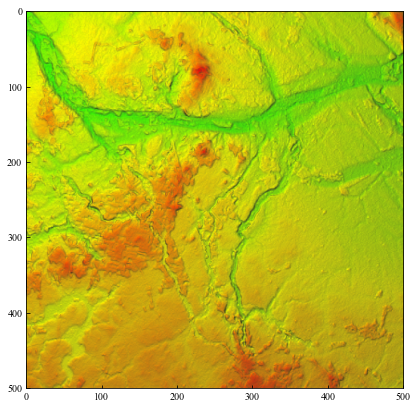

In [10]:
fig = plt.figure(figsize=(500/72, 500/72), dpi = 72)
tick = [0, 100, 200, 300, 400, 500]
ax = plt.imshow(h_map)
ax = plt.gca()
ax.set_xticks(tick)
ax.set_yticks(tick)
ax.set_xticklabels(tick, rotation=0)
ax.set_yticklabels(tick)
ax.tick_params(direction='in')
plt.show()

In [12]:
fig.savefig('height_map.pdf')